In [1]:
# pip install tqdm pillow pandas numpy opencv-python scikit-learn keras tensorflow matplotlib openpyxl

In [2]:
import os
from tqdm import tqdm
import random
from PIL import Image, ImageFilter
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, load_model, save_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from keras.layers import UpSampling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
def create_dataframe(root_folder_path, blurred_folder_path, trainLimit=100, secondary_column='blurred_img_path', prefix='blurred'):
    train_data = []
    validation_data = []

    filter='Pepper'

    validation_excel_path = f'{prefix}_validation.xlsx'
    train_excel_path = f'{prefix}_train.xlsx'
    os.makedirs(blurred_folder_path, exist_ok=True)
    
    for subfolder in tqdm(os.listdir(root_folder_path)):
        if not subfolder.startswith(filter):
            continue

        subfolder_path = os.path.join(root_folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            image_count = 0

            # Create the corresponding subfolder in the blurred folder
            blurred_subfolder_path = os.path.join(blurred_folder_path, subfolder)
            os.makedirs(blurred_subfolder_path, exist_ok=True)

            for file in os.listdir(subfolder_path):
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                    img_path = os.path.join(subfolder_path, file)
                    blurred_img_path = os.path.join(blurred_subfolder_path, file)
                    blur_image(img_path, blurred_img_path, blurRadius=3)

                    if image_count < trainLimit:
                        train_data.append([img_path, blurred_img_path, subfolder])
                    else:
                        validation_data.append([img_path, blurred_img_path, subfolder])

                    image_count += 1

    if train_data:
        train_df = pd.DataFrame(train_data, columns=['original_img_path', secondary_column, 'className'])
        train_df.to_excel(train_excel_path, index=False)
        print(f'Training data saved to {train_excel_path}')
    else:
        print('No training image files found in the specified subfolders.')

    if validation_data:
        validation_df = pd.DataFrame(validation_data, columns=['original_img_path', secondary_column, 'className'])
        validation_df.to_excel(validation_excel_path, index=False)
        print(f'Validation data saved to {validation_excel_path}')
    else:
        print('No validation image files found in the specified subfolders.')
    
def process_images(root_folder_path, output_folder, blurRadius=0):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for subfolder_name in tqdm(os.listdir(root_folder_path)):
        subfolder_path = os.path.join(root_folder_path, subfolder_name)
        if os.path.isdir(subfolder_path):
            output_subfolder_path = os.path.join(output_folder, subfolder_name)
            os.makedirs(output_subfolder_path, exist_ok=True)

            for filename in os.listdir(subfolder_path):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                    input_path = os.path.join(subfolder_path, filename)
                    output_path = os.path.join(output_subfolder_path, filename)

                    image = Image.open(input_path)

                    if blurRadius > 0:
                        image = image.filter(ImageFilter.GaussianBlur(radius=blurRadius))

                    image.save(output_path)

def blur_image(input_path, output_path, blurRadius):
    image = Image.open(input_path)

    if blurRadius > 0:
        blurred_image = image.filter(ImageFilter.GaussianBlur(radius=blurRadius))
        blurred_image.save(output_path)

Load PlantVillage dataset from https://drive.google.com/drive/folders/1VfSbUXEJy5b0OjUn7h8UqD1fy28kTe6Y?usp=sharing

In [4]:
# split images into train and validation
create_dataframe('PlantVillage', 'blurred', 500)

100%|██████████| 15/15 [00:15<00:00,  1.03s/it]


Training data saved to blurred_train.xlsx
Validation data saved to blurred_validation.xlsx


In [5]:
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

def load_and_preprocess_image(img_path):
    image = cv2.imread(img_path)
    # You may need to resize or normalize the image as needed for your task
    # For image deblurring, you might want to resize and normalize images.
    # Example: image = cv2.resize(image, (desired_width, desired_height))
    image = image / 255.0  # Normalize pixel values
    return image

def unblur_images(model, excel_path='blurred_validation.xlsx'):
    output_folder = 'unblurred'
    os.makedirs(output_folder, exist_ok=True)

    data = pd.read_excel(excel_path)

    for _, row in tqdm(data.iterrows()):  # Iterate through rows of the Excel file
        blurred_img_path = row['blurred_img_path']
        class_name = row['className']

        # Load and preprocess the blurred image
        blurred_image = load_and_preprocess_image(blurred_img_path)

        # Predict using the model
        unblurred_image = model.predict(np.array([blurred_image]), verbose=0)[0]

        # Create the subfolder based on the class name
        class_folder = os.path.join(output_folder, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Define the output file path
        output_path = os.path.join(class_folder, os.path.basename(blurred_img_path))

        # Save the unblurred image
        unblurred_image = Image.fromarray(np.uint8(unblurred_image))
        unblurred_image.save(output_path)

Epoch 1/10
25/25 [==============================] - 116s 5s/step - loss: 0.0202 - accuracy: 0.6680 - val_loss: 0.0083 - val_accuracy: 0.8301
Epoch 2/10
25/25 [==============================] - 115s 5s/step - loss: 0.0050 - accuracy: 0.8386 - val_loss: 0.0025 - val_accuracy: 0.8534
Epoch 3/10
25/25 [==============================] - 117s 5s/step - loss: 0.0018 - accuracy: 0.8885 - val_loss: 0.0010 - val_accuracy: 0.9124
Epoch 4/10
25/25 [==============================] - 114s 5s/step - loss: 9.2732e-04 - accuracy: 0.9298 - val_loss: 7.4346e-04 - val_accuracy: 0.9296
Epoch 5/10
25/25 [==============================] - 114s 5s/step - loss: 5.3884e-04 - accuracy: 0.9362 - val_loss: 7.8720e-04 - val_accuracy: 0.9355
Epoch 6/10
25/25 [==============================] - 115s 5s/step - loss: 4.6016e-04 - accuracy: 0.9393 - val_loss: 3.8385e-04 - val_accuracy: 0.9327
Epoch 7/10
25/25 [==============================] - 114s 5s/step - loss: 3.3505e-04 - accuracy: 0.9406 - val_loss: 3.3265e-04 - va

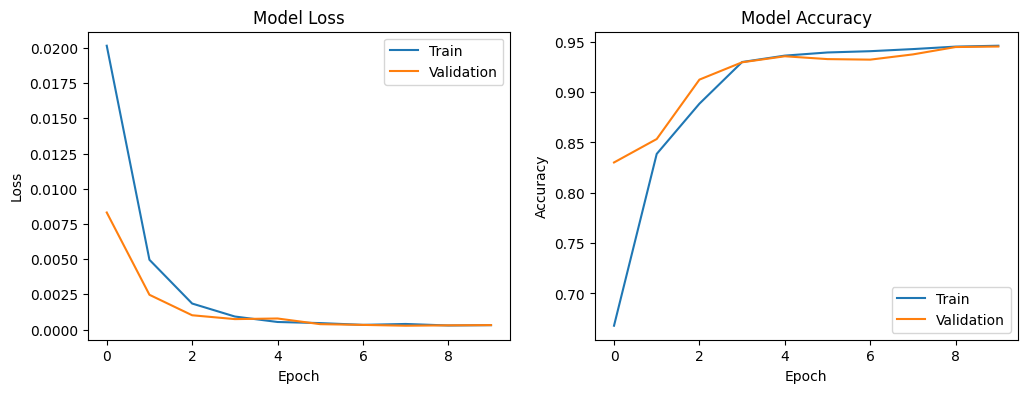

In [6]:
model_file = 'model.h5'
if os.path.exists(model_file):
    model = load_model(model_file)
else:
    data = pd.read_excel('blurred_train.xlsx')
    X = np.array([load_and_preprocess_image(path) for path in data['original_img_path']])
    y = np.array([load_and_preprocess_image(path) for path in data['blurred_img_path']])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3), padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

    plot_history(history)
    model.save(model_file)

In [7]:
unblur_images(model, 'blurred_validation.xlsx')

1475it [02:47,  8.82it/s]


In [8]:
create_dataframe('PlantVillage', 'unblurred', 500, 'unblurred_path', 'unblurred')

100%|██████████| 15/15 [00:15<00:00,  1.04s/it]


Training data saved to unblurred_train.xlsx
Validation data saved to unblurred_validation.xlsx


1/1 [==============================] - 0s 350ms/step
Pepper__bell___healthy


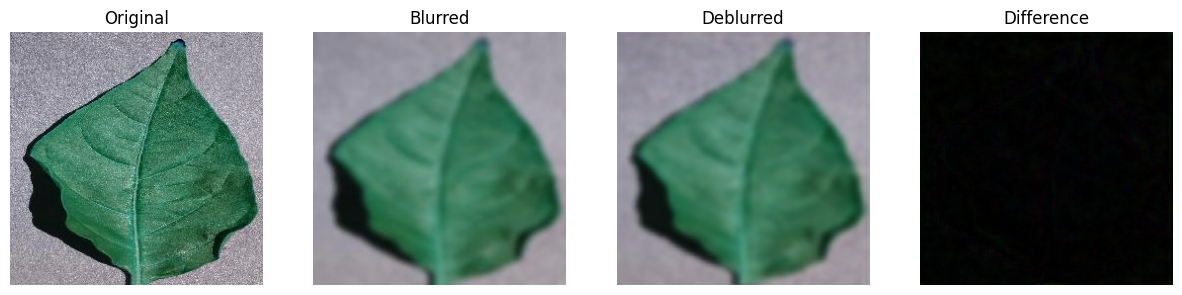

Pepper__bell___Bacterial_spot


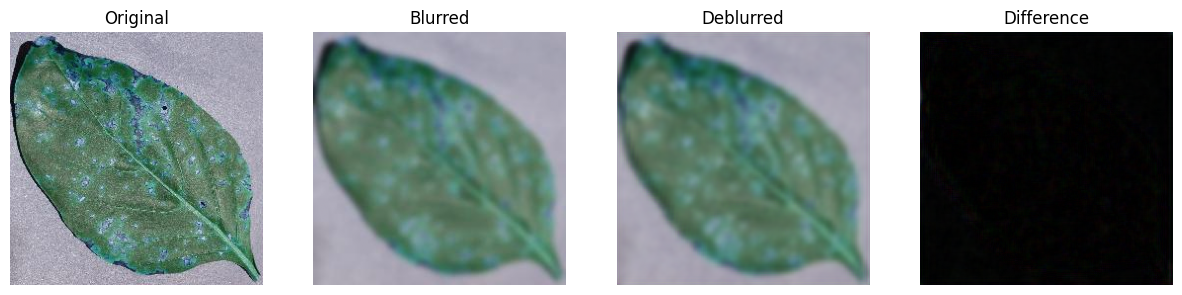

Pepper__bell___healthy


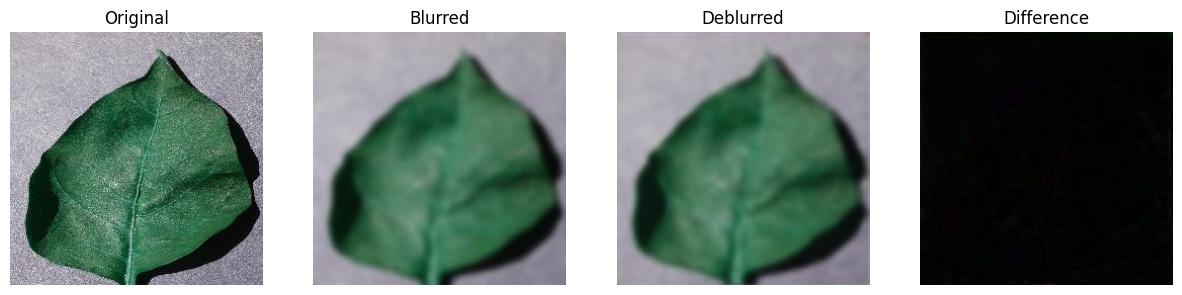

In [9]:
validation = pd.read_excel('blurred_validation.xlsx')
random_sample = validation.sample(n=10)

sample_X = np.array([load_and_preprocess_image(path) for path in random_sample['original_img_path']])
sample_y = np.array([load_and_preprocess_image(path) for path in random_sample['blurred_img_path']])
names = [item for item in random_sample['className']]

# Predict using the model
sample_predictions = model.predict(sample_X)

for i in range(3):
    print(names[i])
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(sample_X[i])
    plt.axis('off')

    # Blurred Image
    plt.subplot(1, 4, 2)
    plt.title("Blurred")
    plt.imshow(sample_y[i])
    plt.axis('off')

    # Deblurred Image (Predicted)
    plt.subplot(1, 4, 3)
    plt.title("Deblurred")
    plt.imshow(sample_predictions[i])
    plt.axis('off')

    # Difference between Blurred and Deblurred
    plt.subplot(1, 4, 4)
    plt.title("Difference")
    diff_image = np.abs(sample_y[i] - sample_predictions[i])
    plt.imshow(diff_image)
    plt.axis('off')

    plt.show()

In [10]:
def classify_data(column):
    df = pd.read_excel('unblurred_train.xlsx')

    X = np.array([load_and_preprocess_image(path) for path in df[column]])
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['className'])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build a simple convolutional model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(df['className'].unique()), activation='softmax'))

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

    plot_history(history)

    y_pred = np.argmax(model.predict(X_test), axis=1)
    print(f"f1_score : {f1_score(y_test, y_pred, average='weighted')}")
    print(f"accuracy_score : {accuracy_score(y_test, y_pred)}")
    print(f"confusion_matrix: \n {confusion_matrix(y_test, y_pred)}")

    return model

c:\Users\tsala\Desktop\poli\mag_1\Машинне навчання\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
25/25 [==============================] - 60s 2s/step - loss: 0.9777 - accuracy: 0.6062 - val_loss: 0.4774 - val_accuracy: 0.8000
Epoch 2/10
25/25 [==============================] - 60s 2s/step - loss: 0.4638 - accuracy: 0.8112 - val_loss: 0.2980 - val_accuracy: 0.8600
Epoch 3/10
25/25 [==============================] - 60s 2s/step - loss: 0.3068 - accuracy: 0.8813 - val_loss: 0.2396 - val_accuracy: 0.9250
Epoch 4/10
25/25 [==============================] - 60s 2s/step - loss: 0.2650 - accuracy: 0.8888 - val_loss: 0.1724 - val_accuracy: 0.9400
Epoch 5/10
25/25 [==============================] - 60s 2s/step - loss: 0.1658 - accuracy: 0.9425 - val_loss: 0.1771 - val_accuracy: 0.9100
Epoch 6/10
25/25 [==============================] - 60s 2s/step - loss: 0.1667 - accuracy: 0.9300 - val_loss: 0.1425 - val_accuracy: 0.9450
Epoch 7/10
25/25 [==============================] - 60s 2s/step - loss: 0.1526 - accuracy: 0.9463 - val_loss: 0.0977 - val_accuracy: 0.9650
Epoch 8/10
25/25 [==

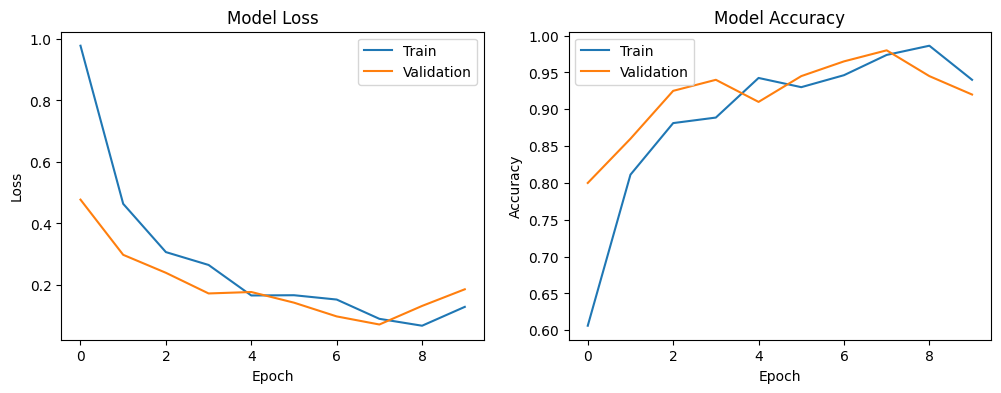

7/7 [==============================] - 3s 467ms/step
f1_score : 0.9195151515151515
accuracy_score : 0.92
confusion_matrix: 
 [[ 82  14]
 [  2 102]]


In [11]:
unblurred_path = classify_data('unblurred_path')

c:\Users\tsala\Desktop\poli\mag_1\Машинне навчання\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
25/25 [==============================] - 60s 2s/step - loss: 2.0177 - accuracy: 0.5325 - val_loss: 0.6828 - val_accuracy: 0.5200
Epoch 2/10
25/25 [==============================] - 59s 2s/step - loss: 0.6209 - accuracy: 0.6475 - val_loss: 0.4977 - val_accuracy: 0.8200
Epoch 3/10
25/25 [==============================] - 61s 2s/step - loss: 0.4001 - accuracy: 0.8375 - val_loss: 0.2184 - val_accuracy: 0.9300
Epoch 4/10
25/25 [==============================] - 59s 2s/step - loss: 0.3557 - accuracy: 0.8587 - val_loss: 0.2911 - val_accuracy: 0.9250
Epoch 5/10
25/25 [==============================] - 59s 2s/step - loss: 0.3152 - accuracy: 0.8737 - val_loss: 0.2231 - val_accuracy: 0.8900
Epoch 6/10
25/25 [==============================] - 60s 2s/step - loss: 0.2294 - accuracy: 0.9162 - val_loss: 0.1776 - val_accuracy: 0.9250
Epoch 7/10
25/25 [==============================] - 60s 2s/step - loss: 0.1624 - accuracy: 0.9350 - val_loss: 0.2475 - val_accuracy: 0.9050
Epoch 8/10
25/25 [==

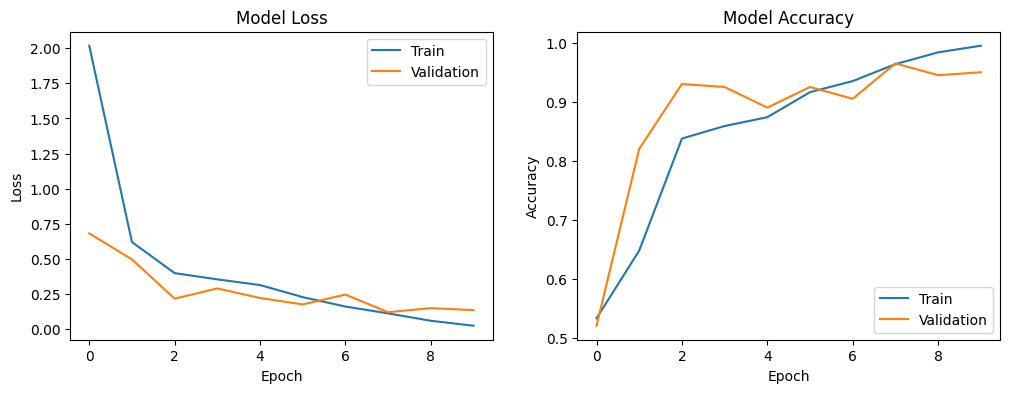

7/7 [==============================] - 3s 467ms/step
f1_score : 0.9500200080032012
accuracy_score : 0.95
confusion_matrix: 
 [[93  3]
 [ 7 97]]


In [12]:
original_img_path = classify_data('original_img_path')

In [13]:
# test = pd.read_excel('unblurred_validation.xlsx')
# num = 10
# random_sample = test.sample(n=num)
# is_original = False

# if is_original:
#     sample_X = np.array([load_and_preprocess_image(path) for path in random_sample['original_img_path']])
#     predicted = original_img_path.predict(sample_X, verbose=0)
# else:
#     sample_X = np.array([load_and_preprocess_image(path) for path in random_sample['unblurred_path']])
#     predicted = unblurred_path.predict(sample_X, verbose=0)

# names = [item for item in random_sample['className']]

# classNames = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

# for i in range(num):
#     plt.figure(figsize=(15, 5))

#     # Original Image
#     plt.subplot(1, 2, 1)
#     plt.title("Original")
#     plt.imshow(sample_X[i])
#     plt.axis('off')

#     plt.show()

#     print(f'predicted : {classNames[np.argmax(predicted[i])]}')
#     print(f'true : {names[i]}')
#     print()
#     print('='*100)

In [14]:
test = pd.read_excel('unblurred_validation.xlsx')
num = 10

original_sample_X = np.array([load_and_preprocess_image(path) for path in test['original_img_path']])
original_img_path_predict = original_img_path.predict(original_sample_X, verbose=0)

unblurred_sample_X = np.array([load_and_preprocess_image(path) for path in test['unblurred_path']])
unblurred_path_predict = original_img_path.predict(unblurred_sample_X, verbose=0)

names = [item for item in test['className']]

classNames = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

plotter = False
unblurred_wrong=0
original_wrong=0

for i in range(len(names)):
    if np.argmax(original_img_path_predict[i]) != np.argmax(unblurred_path_predict[i]):

        if classNames[np.argmax(unblurred_path_predict[i])]!=names[i]:
            unblurred_wrong+=1

        if classNames[np.argmax(original_img_path_predict[i])]!=names[i]:
            original_wrong+=1
            
        if not plotter:
            continue

        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.title(f'predicted: {classNames[np.argmax(original_img_path_predict[i])]}' )
        plt.imshow(original_sample_X[i])
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'predicted: {classNames[np.argmax(unblurred_path_predict[i])]}' )
        plt.imshow(unblurred_sample_X[i])
        plt.axis('off')

        plt.show()

        print(f'actual : {names[i]}')
        print()
        print('='*100)

In [15]:
print(f'percentage of correct predictions for unblurred: {1 - unblurred_wrong/len(names)}')
print(f'percentage of correct predictions for original: {1 - original_wrong/len(names)}')

percentage of correct predictions for unblurred: 0.8725423728813559
percentage of correct predictions for original: 0.9383050847457627
